# ML Analysis
Will attempt to do some sort of clustering.
## Set up Environment

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import cross_val_score

In [66]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

In [67]:
os.listdir(path + 'processed')

['processed_books.csv']

## Pull in required data:

In [68]:
df = pd.read_csv(path + 'processed/processed_books.csv')

In [69]:
df.shape

(29658, 21)

In [70]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group_encoded
0,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,the kitchen god s wife,the kitchen god s wife by amy tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,malaysia,65,0,"(4.0, 26.0]",10.0,1,21.0,8.14523,2


### TF-IDF for Book Info:

In [71]:
tf = TfidfVectorizer(analyzer = "word", ngram_range=(1,2), min_df=0)

In [72]:
tfidf_matrix = tf.fit(df['Book-Info'])

In [73]:
book_vector = tfidf_matrix.transform(df['Book-Info']).toarray()

In [74]:
df['Book-Vector'] = list(book_vector)

## Prepare model:

## Split into train and test set
also want to do cross validation to get mean of models

In [75]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Book-Publisher', 'Book-Author-Processed', 'Book-Publisher-Processed',
       'Book-Title-Processed', 'Book-Info', 'Book-Vector',
       'Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded',
       'User-Country', 'User-Country-Encoded', 'Age-Group-Encoded',
       'Age-Group', 'average_rating', 'times_read', 'average_age',
       'weighted_ratings', 'weighted_ratings_group_encoded'],
      dtype='object')

In [76]:
X = df[['Book-Info', 'User-Country-Encoded', 'Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']]
y = df['weighted_ratings_group_encoded']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [78]:
X_train.head(1)

,Book-Info,User-Country-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
15537,dark force rising star war the thrawn trilogy ...,17,2,7


## Train Model

In [92]:
# Define text preprocessing (TF-IDF vectorization) and numeric preprocessing pipelines
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = "word", ngram_range=(2,2), tokenizer=word_tokenize, stop_words='english'))
])

# Define column transformer to apply different preprocessing to specific columns
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'Book-Info'),
    ('group', 'passthrough', ['Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']),
    ('country', 'passthrough', ['User-Country-Encoded'])
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [93]:
%%time
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

CPU times: user 12.8 s, sys: 325 ms, total: 13.2 s
Wall time: 13.7 s


In [94]:
print("Cross-validation scores:", scores)

Cross-validation scores: [0.42098609 0.42592202 0.42255005 0.41327713 0.4227608 ]


In [95]:
%%time
# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

CPU times: user 3.15 s, sys: 30.9 ms, total: 3.19 s
Wall time: 3.24 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(ngram_range=(2,
                                                                                                2),
                                                                                   stop_words='english',
                                                                                   tokenizer=<function word_tokenize at 0x177b531a0>))]),
                                                  'Book-Info'),
                                                 ('group', 'passthrough',
                                                  ['Age-Group-Encoded',
                                                   'Year-Of-Publication-Group-Encoded']),
                                                 ('country', 'passthrough',
                                                  ['User-Country-Encoded'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [96]:
feature_names = np.concatenate((pipeline.named_steps['preprocessor'].transformers_[0][1]['tfidf'] \
    .get_feature_names_out(),['User-Country-Encoded', 'Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']))
len(feature_names)

8912

In [97]:
importance_scores = pipeline['classifier'].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [106]:
feature_importance_df[feature_importance_df['Feature'].str.contains('potter')]

,Feature,Importance
3462,harry potter,0.001633
6239,potter s,0.000134
6236,potter order,0.000099
6234,potter chamber,0.000071
6240,potter sorcerer,0.000068
6237,potter paperback,0.000022
6238,potter prisoner,0.000000
6235,potter goblet,0.000000
6241,potter und,0.000000
6242,potter y,0.000000


In [99]:
feature_importance_df[feature_importance_df['Feature'].str.contains('j k')]

,Feature,Importance
3946,j k,0.001902


In [100]:
feature_importance_df[feature_importance_df['Feature'].str.contains('stephen')]

,Feature,Importance
7577,stephen king,0.009029
5416,neal stephenson,0.001080
8111,tommyknockers stephen,0.000652
7878,talisman stephen,0.000584
7242,shining stephen,0.000515
...,...,...
3085,game stephen,0.000000
4751,lot stephen,0.000000
4841,macabre stephen,0.000000
4920,man stephen,0.000000


<Axes: xlabel='Importance', ylabel='Feature'>

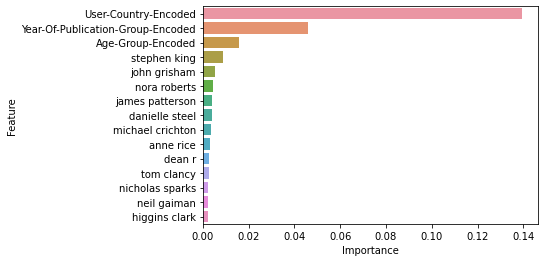

In [103]:
sns.barplot(feature_importance_df.head(15), x = 'Importance', y = 'Feature')

In [107]:
y_pred = pipeline.predict(X_test)

## Results

In [108]:
y_pred_train = pipeline.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Training Set):")
print(classification_report(y_train, y_pred_train))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)

Accuracy: 0.9720559723510074
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6885
           1       0.97      0.97      0.97      8424
           2       1.00      0.95      0.97      8417

    accuracy                           0.97     23726
   macro avg       0.97      0.97      0.97     23726
weighted avg       0.97      0.97      0.97     23726

Confusion Matrix (Training Set):
[[6875    3    7]
 [ 243 8175    6]
 [ 192  212 8013]]


In [109]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix_train)

Accuracy: 0.43240053944706675
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.42      0.35      0.38      1674
           1       0.40      0.52      0.45      2085
           2       0.48      0.42      0.45      2173

    accuracy                           0.43      5932
   macro avg       0.44      0.43      0.43      5932
weighted avg       0.44      0.43      0.43      5932

Confusion Matrix (Test Set):
[[ 578  690  406]
 [ 442 1076  567]
 [ 364  898  911]]


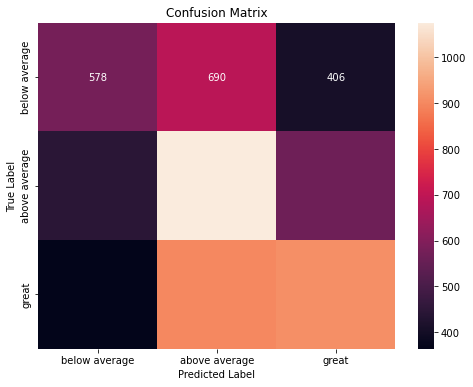

In [110]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
# issue with version of seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, fmt='d', annot = True,
            xticklabels=['below average', 'above average', 'great'],
            yticklabels=['below average', 'above average', 'great'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [111]:
cm

array([[ 578,  690,  406],
       [ 442, 1076,  567],
       [ 364,  898,  911]])

## Able to estimate popularity:

In [120]:
example_dict = {'Book-Info':'harry potter by j k rowling',
                          'User-Country-Encoded':65, 'Age-Group-Encoded':0,
                'Year-Of-Publication-Group-Encoded':7}

X_example = pd.DataFrame(example_dict, index = [0])
X_example

,Book-Info,User-Country-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
0,harry potter by j k rowling,65,0,7


In [121]:
# bins for weighted rating: 4.20336529, 7.57571908, 8.05047939, 9.51708247]
# between 8.050 and 9.517
# great
pipeline.predict(X_example)[0]

1

## Dataset info:

In [63]:
df[['Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded']].drop_duplicates()

,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,"(1989, 1999]",7
47,"(1999, 2009]",8
172,"(1979, 1989]",6
1588,"(1959, 1969]",4
1600,"(1969, 1979]",5
6028,"(1949, 1959]",3
22704,"(1929, 1939]",1


In [64]:
df[['Age-Group', 'Age-Group-Encoded']].drop_duplicates()

,Age-Group,Age-Group-Encoded
0,"(4.0, 26.0]",0
1,"(26.0, 34.0]",1
2,"(46.0, 100.0]",3
5,"(34.0, 46.0]",2


In [65]:
df[['User-Country', 'User-Country-Encoded']].drop_duplicates()

,User-Country,User-Country-Encoded
0,malaysia,65
1,unknown,121
3,usa,124
7,australia,7
8,brazil,15
...,...,...
27737,urugua,122
31652,croatia,25
33861,u.s.a.,115
34124,tajikistan,107


In [66]:
df['weighted_ratings_group_encoded'].drop_duplicates()

0    2
1    1
4    0
Name: weighted_ratings_group_encoded, dtype: int64